# Nano AI-QSAR model project: hyperparameters tuning with BayesSearchCV
Author:Kun Mi

Referred: Wei-Chun Chou (J Control Release. 2023 Sep;361:53-63. )  
Date created: 2024/01/10  
Final version date :2024/05/05

Description: In this study, we used machine learning and Deep nerual network model to predict Nanoparticles biodistribution

# Install and import required python pacakges

In [ ]:
# Install python pacakges
#!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq
# !pip install -q lightgbm # install the lightgbm package
# !pip install -q scikit-optimize # install the package used for Bayesian optimization
# # !pip install -q scikeras[tensorflow]
# !pip install -q tensorflow==2.15.0
# !pip install -q keras-tuner

In [ ]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time

# Link to google drive and set up your project folder

In [ ]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/research"

# choose where you want your project files to be saved
project_folder = "/Heart/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Data exploration

In [ ]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "Nano.csv"))

# Data preprocessing I: missing Values  
Most Machine leanring algorithms canot work with missing features. So, we need to use `SimpleImputer` to replace missing values with median, mean or frequently used values.

In [ ]:
# see how many missing values in your dataset
Data.isna().sum()

,0
No.,0
Type,0
MAT,0
TS,0
CT,0
TM,0
Shape,0
Size,41
Zeta Potential,73
Admin,15


In [ ]:
# Remove the row with missing data
Data=Data.dropna(subset=['Size','Zeta Potential','Admin','DE_tumor' ]) # you can use 'subset' (e.g., dropna(subset='HD')) to remove the missing value in specific column

In [ ]:
#fillter the outliers
df = pd.DataFrame(Data)
q_high=df["DE_tumor"].quantile(0.975)
q_low=df["DE_tumor"].quantile(0.025)
df_filtered=df[(df["DE_tumor"]<q_high)&(df["DE_tumor"]>q_low)]

df_X = df_filtered[["Type","MAT","TS", "CT","TM","Shape","Size","Zeta Potential","Admin" ]]
df_y = df_filtered[["DE_tumor"]]

In [ ]:
## Replace mising value with "Mean" or "Frequency values"
imputer_mean = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer_freq = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
cols_num = ['Size','Zeta Potential','Admin']
cols_label = ['Type','MAT','TS','CT','TM','Shape']

imputer_mean = imputer_mean.fit(df_X[cols_num])
imputer_freq = imputer_freq.fit(df_X[cols_label])
df_X[cols_num] = imputer_mean.transform(df_X[cols_num])
df_X[cols_label] = imputer_freq.transform(df_X[cols_label])

<ipython-input-7-1f220070d19f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X[cols_num] = imputer_mean.transform(df_X[cols_num])
<ipython-input-7-1f220070d19f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X[cols_label] = imputer_freq.transform(df_X[cols_label])


# 3. Taking care of Categorical Features


In [ ]:
test_X = df_X

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode labels of multiple columns at once
test_X[cols_label] = test_X[cols_label].apply(LabelEncoder().fit_transform)

print(test_X)

     Type  MAT  TS  CT  TM  Shape      Size  Zeta Potential      Admin
2       1    1   0   0   2      3  1.623249          -5.000   1.000000
3       1    1   1   0   2      3  1.583199          -5.000   1.000000
4       1    1   0   1   2      0  1.835056          -9.300   4.800000
9       1    1   1  12   3      3  1.807535         -15.000   8.120000
10      1    1   1  12   3      3  2.017868         -10.000  16.240000
..    ...  ...  ..  ..  ..    ...       ...             ...        ...
528     2    7   0   1   2      3  2.203577         -10.980   3.504599
529     2    7   0   1   2      3  2.208979         -10.760   3.504599
530     0    2   0  12   0      3  2.000000         -13.902   0.303488
531     2    8   1   3   1      3  1.301030          -0.300   9.009514
532     2    7   1   6   2      3  2.228144         -17.200  10.014582

[403 rows x 9 columns]


<ipython-input-9-8492093ad7ea>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_X[cols_label] = test_X[cols_label].apply(LabelEncoder().fit_transform)


# 4. Model normalization


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
cols_num = ['Size','Zeta Potential','Admin']

scaler = StandardScaler()
mscaler = MinMaxScaler()

Data_num_tr = pd.DataFrame(mscaler.fit_transform(test_X[cols_num]))
Data_num_tr.columns = list(test_X[cols_num].columns)
print(Data_num_tr)

         Size  Zeta Potential     Admin
0    0.534939        0.440698  0.000774
1    0.516964        0.440698  0.000774
2    0.630002        0.409178  0.003715
3    0.617650        0.367395  0.006285
4    0.712051        0.404046  0.012570
..        ...             ...       ...
398  0.795400        0.396863  0.002713
399  0.797825        0.398475  0.002713
400  0.704031        0.375443  0.000235
401  0.390321        0.475150  0.006973
402  0.806426        0.351268  0.007751

[403 rows x 3 columns]


# Onehot encoder

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)

cols_label_1hot = ['Type','MAT','TS','CT','TM','Shape']
data_cat_1hot = pd.DataFrame(cat_encoder.fit_transform(test_X[cols_label_1hot]))
data_cat_1hot.columns = cat_encoder.get_feature_names_out(cols_label_1hot)

print(data_cat_1hot)

     Type_0  Type_1  Type_2  MAT_0  MAT_1  MAT_2  MAT_3  MAT_4  MAT_5  MAT_6  \
0       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
1       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
2       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
3       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
4       0.0     1.0     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
..      ...     ...     ...    ...    ...    ...    ...    ...    ...    ...   
398     0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
399     0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
400     1.0     0.0     0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
401     0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
402     0.0     0.0     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

     ...  CT_11  CT_12  TM_0  TM_1  TM_

In [ ]:
cols_label_bi = ['Type','MAT','TS','CT','TM','Shape']
data_cat_bi = test_X[cols_label_bi]
preData=pd.concat([Data_num_tr, data_cat_1hot], axis=1)
print(preData)

         Size  Zeta Potential     Admin  Type_0  Type_1  Type_2  MAT_0  MAT_1  \
0    0.534939        0.440698  0.000774     0.0     1.0     0.0    0.0    1.0   
1    0.516964        0.440698  0.000774     0.0     1.0     0.0    0.0    1.0   
2    0.630002        0.409178  0.003715     0.0     1.0     0.0    0.0    1.0   
3    0.617650        0.367395  0.006285     0.0     1.0     0.0    0.0    1.0   
4    0.712051        0.404046  0.012570     0.0     1.0     0.0    0.0    1.0   
..        ...             ...       ...     ...     ...     ...    ...    ...   
398  0.795400        0.396863  0.002713     0.0     0.0     1.0    0.0    0.0   
399  0.797825        0.398475  0.002713     0.0     0.0     1.0    0.0    0.0   
400  0.704031        0.375443  0.000235     1.0     0.0     0.0    0.0    0.0   
401  0.390321        0.475150  0.006973     0.0     0.0     1.0    0.0    0.0   
402  0.806426        0.351268  0.007751     0.0     0.0     1.0    0.0    0.0   

     MAT_2  MAT_3  ...  CT_

# Feature selection

In [ ]:
# # pearson's correlation feature selection for numeric input and numeric output
# from sklearn.datasets import make_regression
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_regression
# # generate dataset
# # X, y = make_regression(n_samples=100, n_features=100, n_informative=10)
# # define feature selection
# fs = SelectKBest(score_func=f_regression, k=5)
# # apply feature selection
# X_selected = pd.DataFrame(fs.fit_transform(preData, df_y['DE_tumor']))
# cols = fs.get_feature_names_out()
# X_selected.columns = cols
# print(X_selected)

In [ ]:
y_re = df_y['DE_tumor']
X_re = preData

In [ ]:
y_re_LR = df_y['DE_tumor']
X_re_LR = preData



# Linear model

In [ ]:
## Split the data after feature selection
from sklearn.model_selection import train_test_split
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_re_LR, y_re_LR, test_size = 0.2, random_state=42)

In [ ]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
#Install packae
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVC,SVR
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
# from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error

import sklearn
print(sklearn.__version__)


1.6.1


In [ ]:
LR_parm_search = [
    { # linear
     'alpha': Real(1, 10, prior='log-uniform'),
     "solver":Categorical(['svd', 'cholesky', 'lsqr', 'sag']),
      "tol":Real(1e-5, 10, prior='log-uniform')
    }]


cv = KFold(n_splits=5, shuffle=True, random_state=77)

bs_LR = BayesSearchCV(
       estimator=Ridge(),
       search_spaces=LR_parm_search,
       cv = cv,
       n_iter = 20,
       n_jobs = -1,
       scoring = "r2",
       return_train_score=True,
       random_state = 2)

np.int=int

bs_LR.fit(X_train_LR, y_train_LR)

model_LR   = bs_LR.best_estimator_
test_preds_LR = model_LR.predict(X_test_LR)
train_preds_LR = model_LR.predict(X_train_LR)
all_preds_LR  = model_LR.predict(X_re_LR)
y_obs_LR    = y_re_LR.tolist()

r2_kfolds_LR = cross_val_score(model_LR, X_train_LR, y_train_LR, cv = cv, n_jobs=-1, scoring='r2')
rmse_kfolds_LR = cross_val_score(model_LR,X_train_LR, y_train_LR, cv = cv, n_jobs=-1, scoring='neg_root_mean_squared_error')

print('\nThe 5-CV rmse Score was:', rmse_kfolds_LR.mean())
print('With a standard deviation of:', rmse_kfolds_LR.std())
rmse = mean_squared_error(y_test_LR, test_preds_LR) ** 0.5
print('Test rmse socre:', rmse)

print('\nThe 5-CV R2 Score was:', r2_kfolds_LR.mean())
print('With a standard deviation of:', r2_kfolds_LR.std())
print("Test R2 Score : %.2f" %r2_score(y_test_LR, test_preds_LR))
print("Train R2 Score : %.2f" %r2_score(y_train_LR, train_preds_LR))
print("All R2 Score : %.2f" %r2_score(y_obs_LR, all_preds_LR))


The 5-CV rmse Score was: -2.420241035761186
With a standard deviation of: 0.247299504948214
Test rmse socre: 2.0499108289563415

The 5-CV R2 Score was: 0.07415615741459378
With a standard deviation of: 0.06956765092622058
Test R2 Score : 0.06
Train R2 Score : 0.20
All R2 Score : 0.18


In [ ]:
bs_LR.best_params_

OrderedDict([('alpha', 6.429541193075915),
             ('solver', 'sag'),
             ('tol', 0.17936564093531993)])

# SVM,RF,XGBoost and LGBM

In [ ]:
#Splet data without data selection
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size = 0.2, random_state=8)

In [ ]:
models_to_run = [
                 SVR(),
                 RandomForestRegressor(),
                 xgb.XGBRegressor(),
                 lgb.LGBMRegressor()
                 ]

model_parm_search = [

    { # SVR
      'C': Real(1e-5,5, prior='log-uniform'),
     "kernel":['rbf'],
     'gamma':Real(1e-6, 0.1, prior='log-uniform'),
      'epsilon':Real(1e-6,1.5, prior='log-uniform')
    },

    { # RandomForestRegressor
     'max_depth': Integer(3, 12),
     'n_estimators': Integer(100, 1000),
     'max_features': Integer(10, 38),
    },

     { # XGBRegressor
     'learning_rate': Real(1e-4, 1.0, 'log-uniform'),
     'colsample_bytree': Real(0.1, 0.9),
     'n_estimators': Integer(100, 1000),
     'reg_alpha': Real(1, 1.5,'log-uniform'),
     'reg_lambda': Real(1, 1.5,'log-uniform'),
    },

    { # LGBMRegressor
     'reg_alpha': Real(1e-6, 1,'log-uniform'),
     'reg_lambda': Real(1e-3, 10,'log-uniform'),
      'learning_rate': Real(1e-4, 10, 'log-uniform'),
      'subsample':[0.4],
      'num_leaves':[770,771,775,780],
      'min_child_samples':[1],
      'min_data_per_groups':[91],
    # 'n_estimators':Integer(100,700),
      'verbose':[-1]
    }

]

In [ ]:
from sklearn.metrics import mean_squared_error as mse

cv = KFold(n_splits=5, shuffle=True, random_state=77)

for i, model in enumerate(models_to_run):
   # build the Bayesian search model

   bs = BayesSearchCV(
       estimator=model,
       search_spaces=model_parm_search[i],
       cv = cv,
       n_iter = 20,
       n_jobs = -1,
       scoring = "r2",
       return_train_score=True,
       random_state = 2)
   np.int=int
   bs.fit(X_train, y_train)

   model    = bs.best_estimator_
   test_preds = model.predict(X_test)
   train_preds = model.predict(X_train)
   all_preds  = model.predict(X_re)
   y_obs    = y_re.tolist()

   r2_kfolds = cross_val_score(model, X_train, y_train, cv = cv, n_jobs=-1, scoring='r2')
   rmse_kfolds = cross_val_score(model, X_train, y_train, cv = cv, n_jobs=-1, scoring='neg_root_mean_squared_error')

   print('\nThe 5-CV rmse Score was:', rmse_kfolds.mean())
   print('With a standard deviation of:', rmse_kfolds.std())
   rmse = mean_squared_error(y_test_LR, test_preds_LR) ** 0.5
   print('Test rmse socre:', rmse)

   print('\nThe 5-CV R2 Score was:', r2_kfolds.mean())
   print('With a standard deviation of:', r2_kfolds.std())
   print("Test R2 Score : %.2f" %r2_score(y_test, test_preds))
   print("Train R2 Score : %.2f" %r2_score(y_train, train_preds))
   print("All R2 Score : %.2f" %r2_score(y_obs, all_preds))


The 5-CV rmse Score was: -2.318266138177367
With a standard deviation of: 0.3013435229666873
Test rmse socre: 2.0499108289563415

The 5-CV R2 Score was: 0.06810758601570936
With a standard deviation of: 0.03370677060925832
Test R2 Score : 0.22
Train R2 Score : 0.24
All R2 Score : 0.23

The 5-CV rmse Score was: -2.2019141147409136
With a standard deviation of: 0.32936765252032907
Test rmse socre: 2.0499108289563415

The 5-CV R2 Score was: 0.16306626001160981
With a standard deviation of: 0.05585871908172565
Test R2 Score : 0.44
Train R2 Score : 0.86
All R2 Score : 0.76

The 5-CV rmse Score was: -2.187917179269619
With a standard deviation of: 0.39159747420680846
Test rmse socre: 2.0499108289563415

The 5-CV R2 Score was: 0.175238596503307
With a standard deviation of: 0.11231276267575999
Test R2 Score : 0.35
Train R2 Score : 0.88
All R2 Score : 0.76

The 5-CV rmse Score was: -2.1738179263440864
With a standard deviation of: 0.3316865838607505
Test rmse socre: 2.0499108289563415

The 5-

In [ ]:
bs.best_params_

OrderedDict([('learning_rate', 0.03627712758228198),
             ('min_child_samples', 1),
             ('min_data_per_groups', 91),
             ('num_leaves', 780),
             ('reg_alpha', 6.343898582939435e-06),
             ('reg_lambda', 6.357872549789344),
             ('subsample', 0.4),
             ('verbose', -1)])

In [ ]:
import joblib
model = bs.best_estimator_
# Save the best estimator
joblib.dump(model, 'random_forest_best_model2.pkl')

['random_forest_best_model2.pkl']

# Ensemble Model


Base Model 1
R2 Score: 0.0498
RMSE: 2.5588


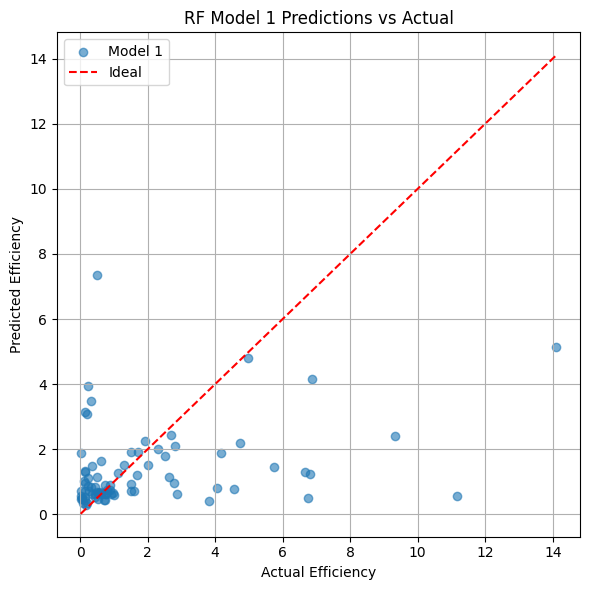


Base Model 2
R2 Score: 0.3612
RMSE: 2.098


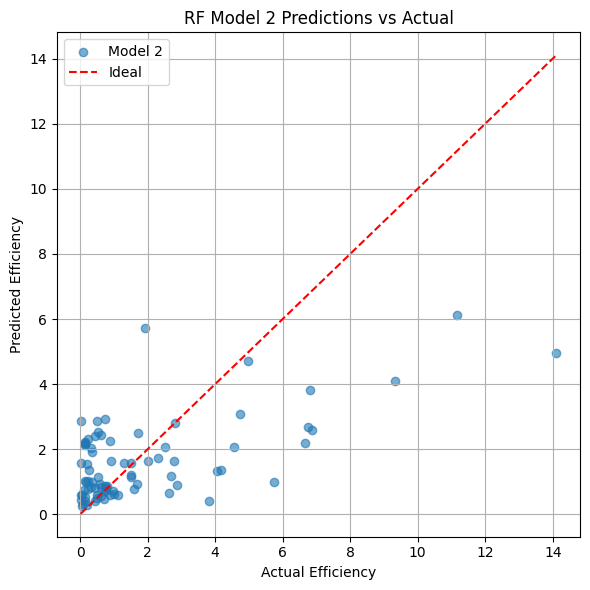


Base Model 3
R2 Score: 0.2392
RMSE: 2.2896


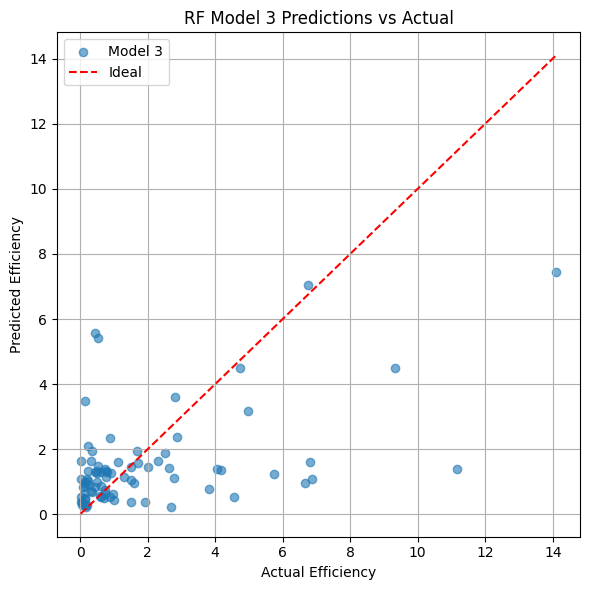


Base Model 4
R2 Score: -0.0709
RMSE: 2.7165


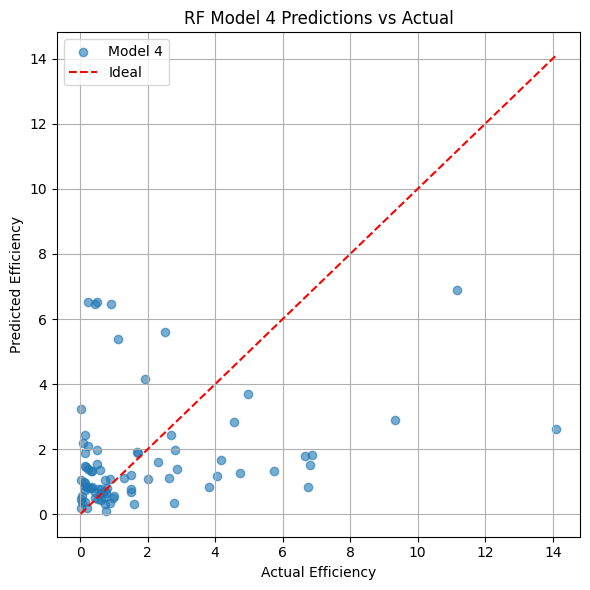


Base Model 5
R2 Score: 0.4018
RMSE: 2.0303


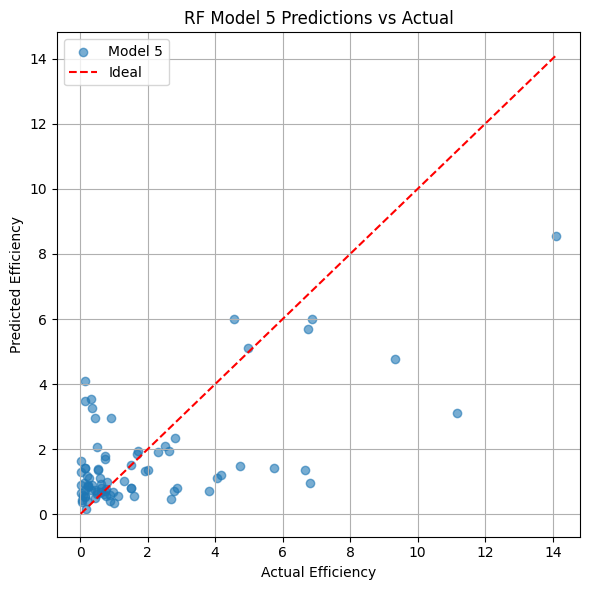


Base Model 6
R2 Score: 0.1484
RMSE: 2.4224


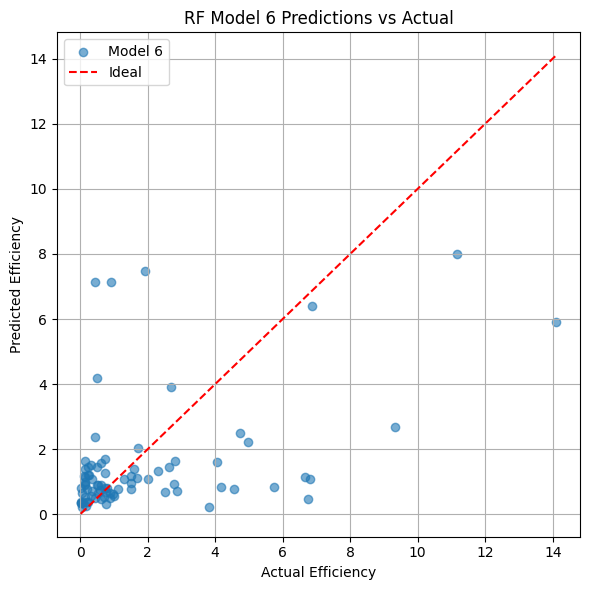


Base Model 7
R2 Score: 0.1606
RMSE: 2.4049


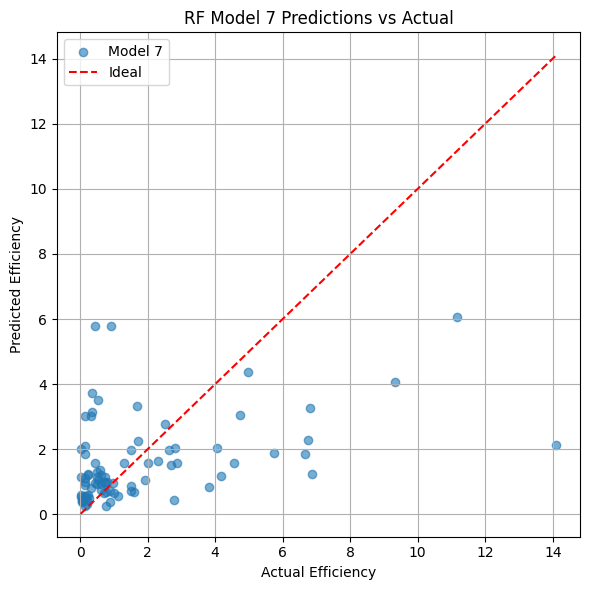


Base Model 8
R2 Score: 0.2873
RMSE: 2.2161


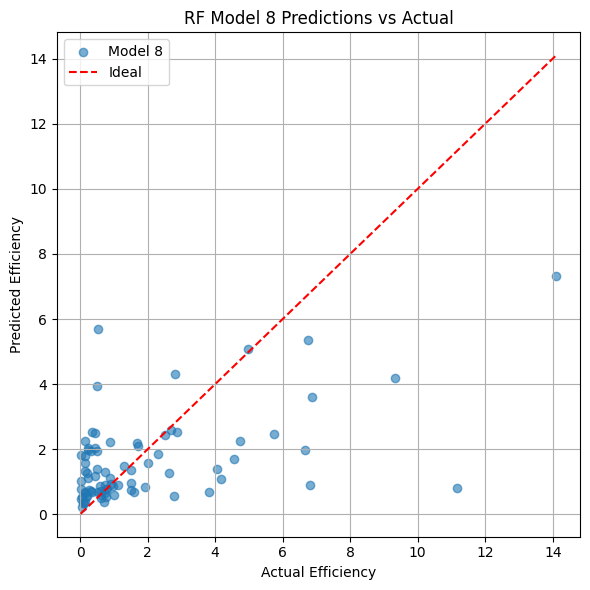


Base Model 9
R2 Score: 0.205
RMSE: 2.3404


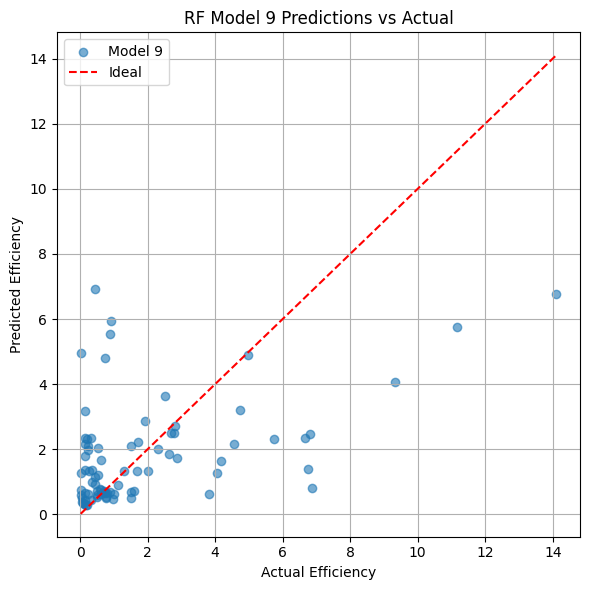


Base Model 10
R2 Score: 0.1461
RMSE: 2.4257


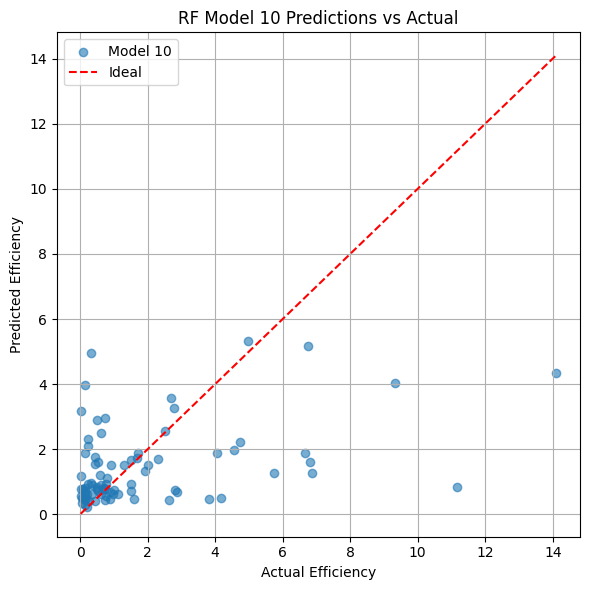


Base Model 11
R2 Score: 0.0633
RMSE: 2.5405


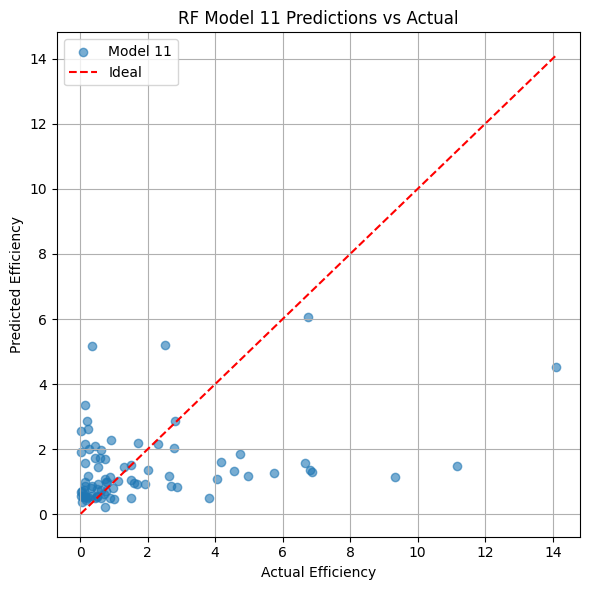


 Summary of Base Models:
Model 1: R2 = 0.0498, RMSE = 2.5588
Model 2: R2 = 0.3612, RMSE = 2.098
Model 3: R2 = 0.2392, RMSE = 2.2896
Model 4: R2 = -0.0709, RMSE = 2.7165
Model 5: R2 = 0.4018, RMSE = 2.0303
Model 6: R2 = 0.1484, RMSE = 2.4224
Model 7: R2 = 0.1606, RMSE = 2.4049
Model 8: R2 = 0.2873, RMSE = 2.2161
Model 9: R2 = 0.205, RMSE = 2.3404
Model 10: R2 = 0.1461, RMSE = 2.4257
Model 11: R2 = 0.0633, RMSE = 2.5405


In [ ]:
import joblib
from sklearn.base import clone
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load base tuned Random Forest
base_rf = joblib.load('random_forest_best_model.pkl')

# Number of models
n_models = 10
bagged_models = []

# Store predictions and scores
all_r2 = []
all_rmse = []

for i in range(n_models):
    # Create bootstrapped training set
    X_sample, y_sample = resample(X_train, y_train, random_state=i)

    # Clone and train model
    model = clone(base_rf)
    model.set_params(random_state=i)
    model.fit(X_sample, y_sample)

    # Save the model
    bagged_models.append(model)

    # Predict on test set
    preds = model.predict(X_test)

    # Evaluate
    r2 = r2_score(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    all_r2.append(r2)
    all_rmse.append(rmse)

    # Print results
    print(f"\nBase Model {i+1}")
    print("R2 Score:", round(r2, 4))
    print("RMSE:", round(rmse, 4))

    # Plot predictions
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, preds, alpha=0.6, label=f"Model {i+1}")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Ideal")
    plt.title(f"RF Model {i+1} Predictions vs Actual")
    plt.xlabel("Actual Efficiency")
    plt.ylabel("Predicted Efficiency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Optional: print summary stats
print("\n Summary of Base Models:")
for i in range(n_models):
    print(f"Model {i+1}: R2 = {round(all_r2[i], 4)}, RMSE = {round(all_rmse[i], 4)}")





In [ ]:
for i, model in enumerate(bagged_models):
    preds = model.predict(X_test)
    print(f"Model {i+1} test mean: {preds.mean():.4f}, std: {preds.std():.4f}")


Model 1 test mean: 1.3298, std: 1.2117
Model 2 test mean: 1.6116, std: 1.2218
Model 3 test mean: 1.4850, std: 1.4088
Model 4 test mean: 1.6676, std: 1.6257
Model 5 test mean: 1.5898, std: 1.5235
Model 6 test mean: 1.5096, std: 1.7146
Model 7 test mean: 1.5924, std: 1.2655
Model 8 test mean: 1.5900, std: 1.3266
Model 9 test mean: 1.7990, std: 1.5626
Model 10 test mean: 1.4418, std: 1.1835


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import joblib
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor

from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# Step 1: Make sure bagged_models has at least 8 models
base_estimators_9rf = [(f"rf{i+1}", model) for i, model in enumerate(bagged_models[:9])]

# Step 2: Define the SVR meta-model pipeline
svr_pipeline = make_pipeline(StandardScaler(), SVR(C=10, epsilon=0.2, kernel='rbf'))


svr_pipeline_9rf = make_pipeline(StandardScaler(), SVR(C=10, epsilon=0.2, kernel='rbf'))

# Create stacking model
stacked_svr_9rf = StackingRegressor(
    estimators=base_estimators_9rf,
    final_estimator=svr_pipeline_9rf,
    passthrough=True,
    n_jobs=-1
)

# Fit the stacking model
stacked_svr_9rf.fit(X_train, y_train)

# Predict
svr_preds_9rf = stacked_svr_9rf.predict(X_test)

# Evaluate
r2_9rf = r2_score(y_test, svr_preds_9rf)
rmse_9rf = np.sqrt(mean_squared_error(y_test, svr_preds_9rf))

# Display results
print(" SVR Meta-Model (9 RFs)")
print("R² Score:", round(r2_9rf, 4))
print("RMSE:", round(rmse_9rf, 4))


 SVR Meta-Model (9 RFs)
R² Score: 0.4842
RMSE: 1.8852


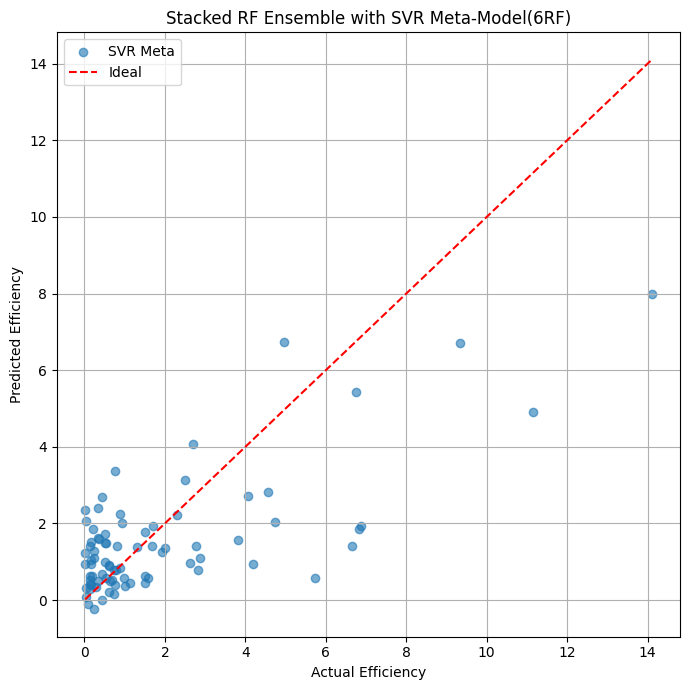

In [ ]:
import matplotlib.pyplot as plt

# Plot: Actual vs Predicted
plt.figure(figsize=(7, 7))
plt.scatter(y_test, svr_preds_9rf, alpha=0.6, label='SVR Meta')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal')

plt.title("Stacked RF Ensemble with SVR Meta-Model(6RF)")
plt.xlabel("Actual Efficiency")
plt.ylabel("Predicted Efficiency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

